# Your First RAG Application

In this notebook, we'll walk you through each of the components that are involved in a simple RAG application.

We won't be leveraging any fancy tools, just the OpenAI Python SDK, Numpy, and some classic Python.

> NOTE: This was done with Python 3.12.3.

> NOTE: There might be [compatibility issues](https://github.com/wandb/wandb/issues/7683) if you're on NVIDIA driver >552.44 As an interim solution - you can rollback your drivers to the 552.44.

## Table of Contents:

- Task 1: Imports and Utilities
- Task 2: Documents
- Task 3: Embeddings and Vectors
- Task 4: Prompts
- Task 5: Retrieval Augmented Generation
  - 🚧 Activity #1: Augment RAG

Let's look at a rather complicated looking visual representation of a basic RAG application.

<img src="https://i.imgur.com/vD8b016.png" />

## Task 1: Imports and Utility

We're just doing some imports and enabling `async` to work within the Jupyter environment here, nothing too crazy!

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter
from aimakerspace.youtube_utils import YouTubeTranscriptLoader
# import aimakerspace.vectordatabase
from aimakerspace.vectordatabase import VectorDatabase
import asyncio
# import importlib
# importlib.reload(aimakerspace.vectordatabase)
from dotenv import load_dotenv
import inspect
load_dotenv()

True

In [3]:
# sig = inspect.signature(VectorDatabase.insert)
# print("After reload - method signature:", sig)

In [3]:
import nest_asyncio
nest_asyncio.apply()

## Task 2: Documents

We'll be concerning ourselves with this part of the flow in the following section:

<img src="https://i.imgur.com/jTm9gjk.png" />

### Loading Source Documents

So, first things first, we need some documents to work with.

While we could work directly with the `.txt` files (or whatever file-types you wanted to extend this to) we can instead do some batch processing of those documents at the beginning in order to store them in a more machine compatible format.

In this case, we're going to parse our text file into a single document in memory.

Let's look at the relevant bits of the `TextFileLoader` class:

```python
def load_file(self):
        with open(self.path, "r", encoding=self.encoding) as f:
            self.documents.append(f.read())
```

We're simply loading the document using the built in `open` method, and storing that output in our `self.documents` list.

> NOTE: We're using blogs from PMarca (Marc Andreessen) as our sample data. This data is largely irrelevant as we want to focus on the mechanisms of RAG, which includes out data's shape and quality - but not specifically what the contents of the data are. 


In [4]:
text_loader = TextFileLoader("data/PMarcaBlogs.txt")
documents = text_loader.load_documents()
len(documents)

1

In [5]:
print(documents[0][:100])


The Pmarca Blog Archives
(select posts from 2007-2009)
Marc Andreessen
copyright: Andreessen Horow


### Splitting Text Into Chunks

As we can see, there is one massive document.

We'll want to chunk the document into smaller parts so it's easier to pass the most relevant snippets to the LLM.

There is no fixed way to split/chunk documents - and you'll need to rely on some intuition as well as knowing your data *very* well in order to build the most robust system.

For this toy example, we'll just split blindly on length.

>There's an opportunity to clear up some terminology here, for this course we will be stick to the following:
>
>- "source documents" : The `.txt`, `.pdf`, `.html`, ..., files that make up the files and information we start with in its raw format
>- "document(s)" : single (or more) text object(s)
>- "corpus" : the combination of all of our documents

As you can imagine (though it's not specifically true in this toy example) the idea of splitting documents is to break them into managable sized chunks that retain the most relevant local context.

In [5]:
text_splitter = CharacterTextSplitter()
split_documents = text_splitter.split_texts(documents)
len(split_documents)

373

Let's take a look at some of the documents we've managed to split.

In [7]:
split_documents[0:1]

['\ufeff\nThe Pmarca Blog Archives\n(select posts from 2007-2009)\nMarc Andreessen\ncopyright: Andreessen Horowitz\ncover design: Jessica Hagy\nproduced using: Pressbooks\nContents\nTHE PMARCA GUIDE TO STARTUPS\nPart 1: Why not to do a startup 2\nPart 2: When the VCs say "no" 10\nPart 3: "But I don\'t know any VCs!" 18\nPart 4: The only thing that matters 25\nPart 5: The Moby Dick theory of big companies 33\nPart 6: How much funding is too little? Too much? 41\nPart 7: Why a startup\'s initial business plan doesn\'t\nmatter that much\n49\nTHE PMARCA GUIDE TO HIRING\nPart 8: Hiring, managing, promoting, and Dring\nexecutives\n54\nPart 9: How to hire a professional CEO 68\nHow to hire the best people you\'ve ever worked\nwith\n69\nTHE PMARCA GUIDE TO BIG COMPANIES\nPart 1: Turnaround! 82\nPart 2: Retaining great people 86\nTHE PMARCA GUIDE TO CAREER, PRODUCTIVITY,\nAND SOME OTHER THINGS\nIntroduction 97\nPart 1: Opportunity 99\nPart 2: Skills and education 107\nPart 3: Where to go and wh

## Task 3: Embeddings and Vectors

Next, we have to convert our corpus into a "machine readable" format as we explored in the Embedding Primer notebook.

Today, we're going to talk about the actual process of creating, and then storing, these embeddings, and how we can leverage that to intelligently add context to our queries.

### OpenAI API Key

In order to access OpenAI's APIs, we'll need to provide our OpenAI API Key!

You can work through the folder "OpenAI API Key Setup" for more information on this process if you don't already have an API Key!

In [6]:
import os
import openai
from getpass import getpass


# openai.api_key = getpass("OpenAI API Key: ")
# os.environ["OPENAI_API_KEY"] = openai.api_key

### Vector Database

Let's set up our vector database to hold all our documents and their embeddings!

While this is all baked into 1 call - we can look at some of the code that powers this process to get a better understanding:

Let's look at our `VectorDatabase().__init__()`:

```python
def __init__(self, embedding_model: EmbeddingModel = None):
        self.vectors = defaultdict(np.array)
        self.embedding_model = embedding_model or EmbeddingModel()
```

As you can see - our vectors are merely stored as a dictionary of `np.array` objects.

Secondly, our `VectorDatabase()` has a default `EmbeddingModel()` which is a wrapper for OpenAI's `text-embedding-3-small` model.

> **Quick Info About `text-embedding-3-small`**:
> - It has a context window of **8191** tokens
> - It returns vectors with dimension **1536**

#### ❓Question #1:

The default embedding dimension of `text-embedding-3-small` is 1536, as noted above. 

1. Is there any way to modify this dimension?
2. What technique does OpenAI use to achieve this?

> NOTE: Check out this [API documentation](https://platform.openai.com/docs/api-reference/embeddings/create) for the answer to question #1.1, and [this documentation](https://platform.openai.com/docs/guides/embeddings/use-cases) for an answer to question #1.2!


##### ✅ Answer:
1. For newer models such as `text-embedding-3-small` or `text-embedding-3-large`, you can use the `dimensions` parameter to modify the dimensions at generation time; this allows you to shorten the embeddings while trading off some performance for lower cost of storage and  usage
2. The technique used by OpenAI is called `Matryoshka Representation Learning`



We can call the `async_get_embeddings` method of our `EmbeddingModel()` on a list of `str` and receive a list of `float` back!

```python
async def async_get_embeddings(self, list_of_text: List[str]) -> List[List[float]]:
        return await aget_embeddings(
            list_of_text=list_of_text, engine=self.embeddings_model_name
        )
```

We cast those to `np.array` when we build our `VectorDatabase()`:

```python
async def abuild_from_list(self, list_of_text: List[str]) -> "VectorDatabase":
        embeddings = await self.embedding_model.async_get_embeddings(list_of_text)
        for text, embedding in zip(list_of_text, embeddings):
            self.insert(text, np.array(embedding))
        return self
```

And that's all we need to do!

In [8]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

#### ❓Question #2:

What are the benefits of using an `async` approach to collecting our embeddings?

> NOTE: Determining the core difference between `async` and `sync` will be useful! If you get stuck - ask ChatGPT!

##### ✅ Answer:
async operations are non-blocking, which is useful when making network I/O calls. So, if one process is busy generating embeddings, other processes needn't wait until the embedding generation is completed; this is not the case with sync operations, which are blocking. This affects performance. Since these API calls are expensive, we should use async API calls


So, to review what we've done so far in natural language:

1. We load source documents
2. We split those source documents into smaller chunks (documents)
3. We send each of those documents to the `text-embedding-3-small` OpenAI API endpoint
4. We store each of the text representations with the vector representations as keys/values in a dictionary

### Semantic Similarity

The next step is to be able to query our `VectorDatabase()` with a `str` and have it return to us vectors and text that is most relevant from our corpus.

We're going to use the following process to achieve this in our toy example:

1. We need to embed our query with the same `EmbeddingModel()` as we used to construct our `VectorDatabase()`
2. We loop through every vector in our `VectorDatabase()` and use a distance measure to compare how related they are
3. We return a list of the top `k` closest vectors, with their text representations

There's some very heavy optimization that can be done at each of these steps - but let's just focus on the basic pattern in this notebook.

> We are using [cosine similarity](https://www.engati.com/glossary/cosine-similarity) as a distance metric in this example - but there are many many distance metrics you could use - like [these](https://flavien-vidal.medium.com/similarity-distances-for-natural-language-processing-16f63cd5ba55)

> We are using a rather inefficient way of calculating relative distance between the query vector and all other vectors - there are more advanced approaches that are much more efficient, like [ANN](https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6)

In [10]:
vector_db.search_by_text("What is the Michael Eisner Memorial Weak Executive Problem?", k=3)

[('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product manager who has a weak\nproduct management executive. The CEO who used to be in\nsales who has a weak sales executive. The CEO who used to be\nin marketing who has a weak marketing executive.\nI call this the “Michael Eisner Memorial Weak Executive Problem” — aaer the CEO of Disney who had previously been a brilliant TV network executive. When he bought ABC at Disney, it\npromptly fell to fourth place. His response? “If I had an extra\ntwo days a week, I could turn around ABC myself.” Well, guess\nwhat, he didn’t have an extra two days a week.\nA CEO — or a startup founder — oaen has a hard time letting\ngo of the function that brought him to the party. The result: you\nhire someone weak into the executive role for that function so\nthat you can continue to b

## Task 4: Prompts

In the following section, we'll be looking at the role of prompts - and how they help us to guide our application in the right direction.

In this notebook, we're going to rely on the idea of "zero-shot in-context learning".

This is a lot of words to say: "We will ask it to perform our desired task in the prompt, and provide no examples."

### XYZRolePrompt

Before we do that, let's stop and think a bit about how OpenAI's chat models work.

We know they have roles - as is indicated in the following API [documentation](https://platform.openai.com/docs/api-reference/chat/create#chat/create-messages)

There are three roles, and they function as follows (taken directly from [OpenAI](https://platform.openai.com/docs/guides/gpt/chat-completions-api)):

- `{"role" : "system"}` : The system message helps set the behavior of the assistant. For example, you can modify the personality of the assistant or provide specific instructions about how it should behave throughout the conversation. However note that the system message is optional and the model’s behavior without a system message is likely to be similar to using a generic message such as "You are a helpful assistant."
- `{"role" : "user"}` : The user messages provide requests or comments for the assistant to respond to.
- `{"role" : "assistant"}` : Assistant messages store previous assistant responses, but can also be written by you to give examples of desired behavior.

The main idea is this:

1. You start with a system message that outlines how the LLM should respond, what kind of behaviours you can expect from it, and more
2. Then, you can provide a few examples in the form of "assistant"/"user" pairs
3. Then, you prompt the model with the true "user" message.

In this example, we'll be forgoing the 2nd step for simplicities sake.

#### Utility Functions

You'll notice that we're using some utility functions from the `aimakerspace` module - let's take a peek at these and see what they're doing!

##### XYZRolePrompt

Here we have our `system`, `user`, and `assistant` role prompts.

Let's take a peek at what they look like:

```python
class BasePrompt:
    def __init__(self, prompt):
        """
        Initializes the BasePrompt object with a prompt template.

        :param prompt: A string that can contain placeholders within curly braces
        """
        self.prompt = prompt
        self._pattern = re.compile(r"\{([^}]+)\}")

    def format_prompt(self, **kwargs):
        """
        Formats the prompt string using the keyword arguments provided.

        :param kwargs: The values to substitute into the prompt string
        :return: The formatted prompt string
        """
        matches = self._pattern.findall(self.prompt)
        return self.prompt.format(**{match: kwargs.get(match, "") for match in matches})

    def get_input_variables(self):
        """
        Gets the list of input variable names from the prompt string.

        :return: List of input variable names
        """
        return self._pattern.findall(self.prompt)
```

Then we have our `RolePrompt` which laser focuses us on the role pattern found in most API endpoints for LLMs.

```python
class RolePrompt(BasePrompt):
    def __init__(self, prompt, role: str):
        """
        Initializes the RolePrompt object with a prompt template and a role.

        :param prompt: A string that can contain placeholders within curly braces
        :param role: The role for the message ('system', 'user', or 'assistant')
        """
        super().__init__(prompt)
        self.role = role

    def create_message(self, **kwargs):
        """
        Creates a message dictionary with a role and a formatted message.

        :param kwargs: The values to substitute into the prompt string
        :return: Dictionary containing the role and the formatted message
        """
        return {"role": self.role, "content": self.format_prompt(**kwargs)}
```

We'll look at how the `SystemRolePrompt` is constructed to get a better idea of how that extension works:

```python
class SystemRolePrompt(RolePrompt):
    def __init__(self, prompt: str):
        super().__init__(prompt, "system")
```

That pattern is repeated for our `UserRolePrompt` and our `AssistantRolePrompt` as well.

##### ChatOpenAI

Next we have our model, which is converted to a format analagous to libraries like LangChain and LlamaIndex.

Let's take a peek at how that is constructed:

```python
class ChatOpenAI:
    def __init__(self, model_name: str = "gpt-4.1-mini"):
        self.model_name = model_name
        self.openai_api_key = os.getenv("OPENAI_API_KEY")
        if self.openai_api_key is None:
            raise ValueError("OPENAI_API_KEY is not set")

    def run(self, messages, text_only: bool = True):
        if not isinstance(messages, list):
            raise ValueError("messages must be a list")

        openai.api_key = self.openai_api_key
        response = openai.ChatCompletion.create(
            model=self.model_name, messages=messages
        )

        if text_only:
            return response.choices[0].message.content

        return response
```

#### ❓ Question #3:

When calling the OpenAI API - are there any ways we can achieve more reproducible outputs?

> NOTE: Check out [this section](https://platform.openai.com/docs/guides/text-generation/) of the OpenAI documentation for the answer!

##### ✅ Answer:
There are two parameters: `seed` and `temperature`
The `seed` parameter If specified, our system will make a best effort to sample deterministically, such that repeated requests with the same seed and parameters should return the same result.

Determinism is not guaranteed, and you should refer to the system_fingerprint response parameter to monitor changes in the backend.

The `temperature` parameters determines how random or deterministic the output response will be. At a `temperature=0.`,the output is deterministic, and at the other extreme, `temperature=2.`, the output response is very random/creative. So, depending on your usecase, you can tweak this parameter


### Creating and Prompting OpenAI's `gpt-4.1-mini`!

Let's tie all these together and use it to prompt `gpt-4.1-mini`!

In [16]:
from aimakerspace.openai_utils.prompts import (
    UserRolePrompt,
    SystemRolePrompt,
    AssistantRolePrompt,
)

from aimakerspace.openai_utils.chatmodel import ChatOpenAI

chat_openai = ChatOpenAI()
user_prompt_template = "{content}"
user_role_prompt = UserRolePrompt(user_prompt_template)
system_prompt_template = (
    "You are an expert in {expertise}, you always answer in a kind way."
)
system_role_prompt = SystemRolePrompt(system_prompt_template)

messages = [
    system_role_prompt.create_message(expertise="Python"),
    user_role_prompt.create_message(
        content="What is the best way to write a loop?"
    ),
]

response = chat_openai.run(messages)

In [12]:
print(response)

Hello! The best way to write a loop in Python often depends on what you want to achieve, but generally, using a `for` loop is a very clear and Pythonic way to iterate over a sequence (like lists, strings, or ranges). Here's a simple example:

```python
for i in range(5):
    print(i)
```

This will print numbers from 0 to 4. If you want to loop until a certain condition is met, a `while` loop might be more appropriate:

```python
count = 0
while count < 5:
    print(count)
    count += 1
```

If you have a specific task in mind, feel free to share it, and I can help you write the most suitable loop for it!


## Task 5: Retrieval Augmented Generation

Now we can create a RAG prompt - which will help our system behave in a way that makes sense!

There is much you could do here, many tweaks and improvements to be made!

In [10]:
RAG_SYSTEM_TEMPLATE = """You are a knowledgeable assistant that answers questions based strictly on provided context.

Instructions:
- Only answer questions using information from the provided context
- If the context doesn't contain relevant information, respond with "I don't know"
- Be accurate and cite specific parts of the context when possible
- Keep responses {response_style} and {response_length}
- Only use the provided context. Do not use external knowledge.
- Only provide answers when you are confident the context supports your response."""

RAG_USER_TEMPLATE = """Context Information:
{context}

Number of relevant sources found: {context_count}
{similarity_scores}

Question: {user_query}

Please provide your answer based solely on the context above."""

rag_system_prompt = SystemRolePrompt(
    RAG_SYSTEM_TEMPLATE,
    strict=True,
    defaults={
        "response_style": "concise",
        "response_length": "brief"
    }
)

rag_user_prompt = UserRolePrompt(
    RAG_USER_TEMPLATE,
    strict=True,
    defaults={
        "context_count": "",
        "similarity_scores": ""
    }
)

Now we can create our pipeline!

In [22]:
class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI, vector_db_retriever: VectorDatabase, 
                 response_style: str = "detailed", include_scores: bool = False) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever
        self.response_style = response_style
        self.include_scores = include_scores

    def run_pipeline(self, user_query: str, k: int = 4, **system_kwargs) -> dict:
        # Retrieve relevant contexts
        context_list = self.vector_db_retriever.search_by_text(user_query, k=k)
        
        context_prompt = ""
        similarity_scores = []
        
        for i, (context, score) in enumerate(context_list, 1):
            context_prompt += f"[Source {i}]: {context}\n\n"
            similarity_scores.append(f"Source {i}: {score:.3f}")
        
        # Create system message with parameters
        system_params = {
            "response_style": self.response_style,
            "response_length": system_kwargs.get("response_length", "detailed")
        }
        
        formatted_system_prompt = rag_system_prompt.create_message(**system_params)
        
        user_params = {
            "user_query": user_query,
            "context": context_prompt.strip(),
            "context_count": len(context_list),
            "similarity_scores": f"Relevance scores: {', '.join(similarity_scores)}" if self.include_scores else ""
        }
        
        formatted_user_prompt = rag_user_prompt.create_message(**user_params)

        return {
            "response": self.llm.run([formatted_system_prompt, formatted_user_prompt]), 
            "context": context_list,
            "context_count": len(context_list),
            "similarity_scores": similarity_scores if self.include_scores else None,
            "prompts_used": {
                "system": formatted_system_prompt,
                "user": formatted_user_prompt
            }
        }

In [15]:
rag_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai,
    response_style="detailed",
    include_scores=True
)

result = rag_pipeline.run_pipeline(
    "What is the 'Michael Eisner Memorial Weak Executive Problem'?",
    k=3,
    response_length="comprehensive", 
    include_warnings=True,
    confidence_required=True
)

print(f"Response: {result['response']}")
print(f"\nContext Count: {result['context_count']}")
print(f"Similarity Scores: {result['similarity_scores']}")

Response: The "Michael Eisner Memorial Weak Executive Problem" refers to a common situation where a CEO or startup founder, who used to excel in a particular function (such as product management, sales, or marketing), hires a weak executive to run that same function after moving on to the CEO role. The CEO often has a hard time letting go of the function that brought them success and, as a result, intentionally hires a weak executive so that they can continue to be "the man" or maintain control over that area. This was exemplified by Michael Eisner, the CEO of Disney, who had been a brilliant TV network executive but, after buying ABC, saw it fall to fourth place. He claimed he could turn ABC around if he had extra time, but he did not, illustrating the problem of weak executives being hired into roles once managed by the CEO (Source 1).

Context Count: 3
Similarity Scores: ['Source 1: 0.658', 'Source 2: 0.509', 'Source 3: 0.479']


#### ❓ Question #4:

What prompting strategies could you use to make the LLM have a more thoughtful, detailed response?

What is that strategy called?

> NOTE: You can look through our [OpenAI Responses API](https://colab.research.google.com/drive/14SCfRnp39N7aoOx8ZxadWb0hAqk4lQdL?usp=sharing) notebook for an answer to this question if you get stuck!

##### ✅ Answer:
Chain of Thought prompting is the main strategy - asking the model to "think step by step" or "explain your reasoning" before giving the final answer. This leads to more detailed, thoughtful responses.
Other basic strategies:

Role prompting - Ask the model to act as an expert in the field<br>
Few-shot prompting - Provide examples of the detailed response format you want<br>
Structured prompting - Request specific organization like "first analyze X, then Y, then conclude"

Chain of Thought (CoT) prompting - the technique that encourages models to show their reasoning process rather than jumping directly to conclusions.

### 🏗️ Activity #1:

Enhance your RAG application in some way! 

Suggestions are: 

- Allow it to work with PDF files
- Implement a new distance metric
- Add metadata support to the vector database
- Use a different embedding model
- Add the capability to ingest a YouTube link

While these are suggestions, you should feel free to make whatever augmentations you desire! If you shared an idea during Session 1, think about features you might need to incorporate for your use case! 

When you're finished making the augments to your RAG application - vibe check it against the old one - see if you can "feel the improvement"!

> NOTE: These additions might require you to work within the `aimakerspace` library - that's expected!

> NOTE: If you're not sure where to start - ask Cursor (CMD/CTRL+L) to guide you through the changes!

In [16]:
### YOUR CODE HERE

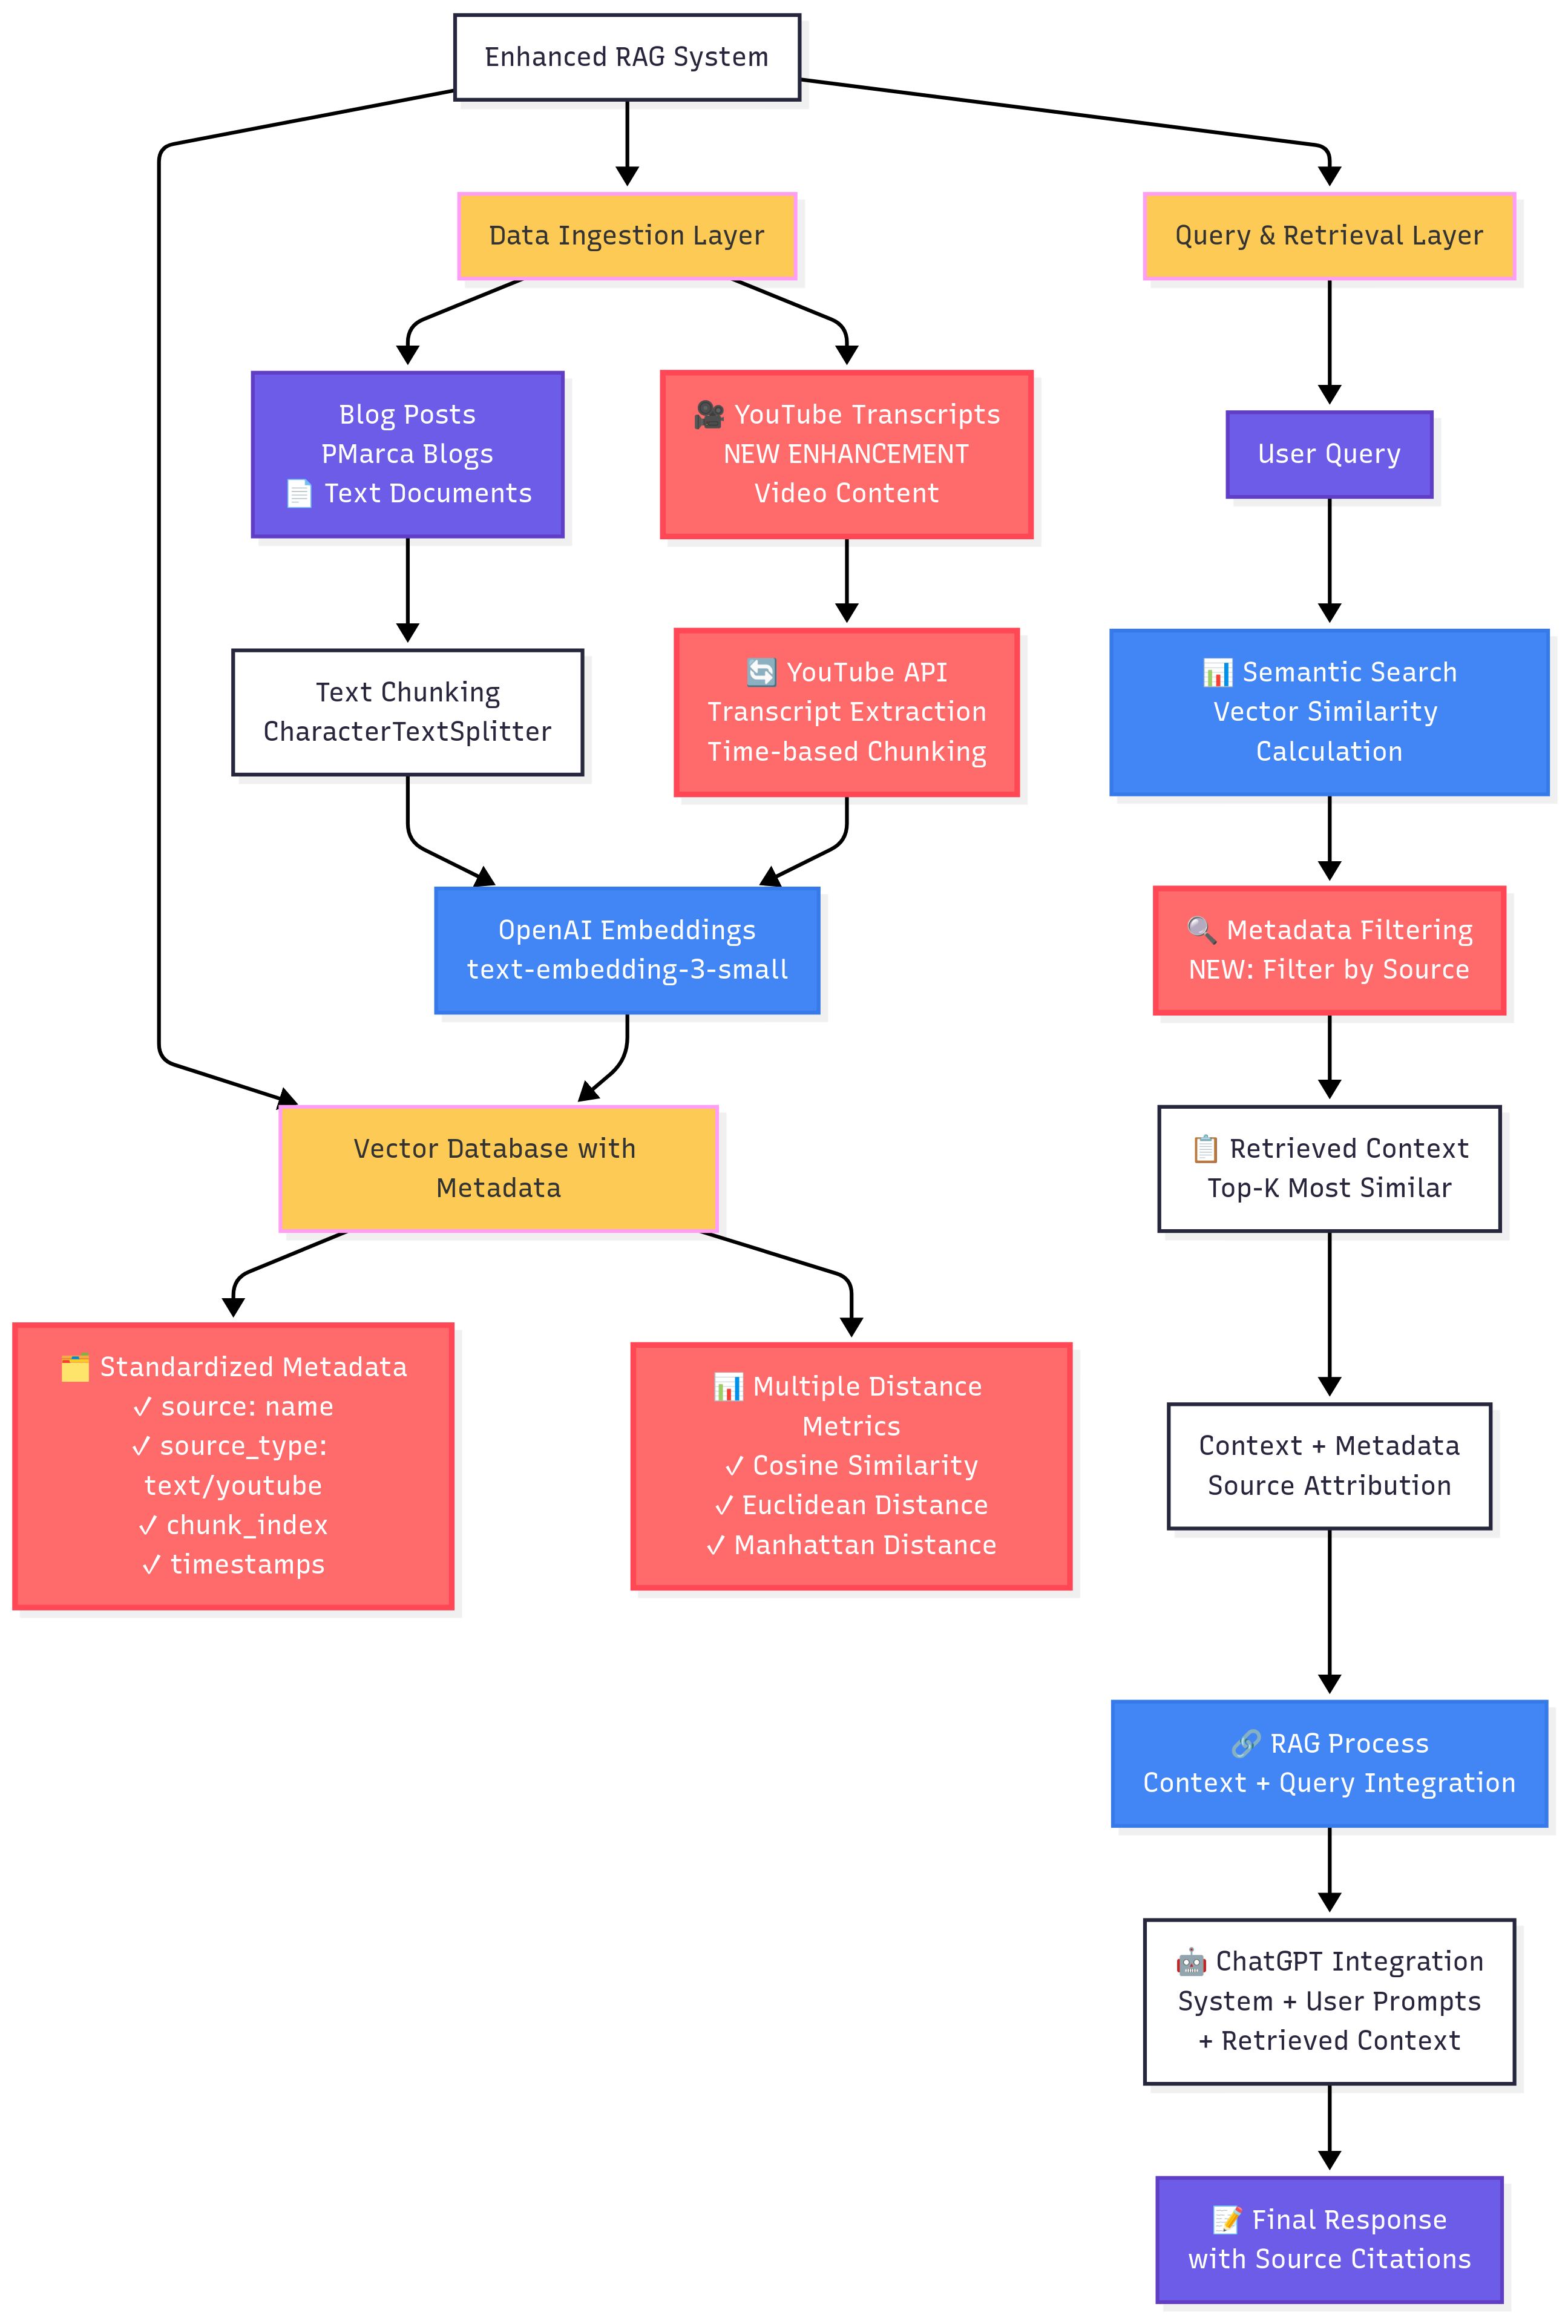

In [119]:
from IPython.display import Image
Image(filename='assets/architecture_diagram.png')

In [112]:
import asyncio
import os
from typing import Dict, List, Any
from dotenv import load_dotenv
load_dotenv()

# Import your existing modules
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter
from aimakerspace.vectordatabase import VectorDatabase
from aimakerspace.youtube_utils import YouTubeTranscriptLoader
from aimakerspace.openai_utils.prompts import UserRolePrompt, SystemRolePrompt
from aimakerspace.openai_utils.chatmodel import ChatOpenAI
from aimakerspace.vectordatabase import(
    cosine_similarity,
    euclidean_distance, 
    manhattan_distance
) 
from typing import Any, List, Dict, Optional, Tuple
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
"""
Enhanced RAG System Demo
This script demonstrates a RAG system that can ingest both text documents and YouTube transcripts.
"""

class EnhancedRAGDemo:
    def __init__(self):
        self.vector_db = VectorDatabase()
        self.chat_openai = ChatOpenAI()
        self.youtube_loader = YouTubeTranscriptLoader(language='en')
        
        # RAG prompts
        self.system_prompt = SystemRolePrompt(
            """You are a knowledgeable assistant that answers questions based strictly on provided context.

            Instructions:
            - Only answer questions using information from the provided context
            - If the context doesn't contain relevant information, respond with "I don't know"
            - Be accurate and cite specific parts of the context when possible
            - Keep responses detailed and comprehensive
            - Only use the provided context. Do not use external knowledge."""
        )
        
        self.user_prompt = UserRolePrompt(
            """Context Information:
            {context}

            Question: {user_query}

            Please provide your answer based solely on the context above."""
        )


    def load_blog_documents(self, file_path: str = "data/PMarcaBlogs.txt") -> List[str]:
        """Load and split blog documents."""
        print("Loading blog documents...")
        try:
            text_loader = TextFileLoader(file_path)
            documents = text_loader.load_documents()
            
            text_splitter = CharacterTextSplitter()
            split_documents = text_splitter.split_texts(documents)
            
            print(f"Loaded {len(split_documents)} blog document chunks")
            return split_documents
        except Exception as e:
            print(f"Error loading blog documents: {e}")
            return []

    def load_youtube_transcript(self, video_url: str) -> List[str]:
        """Load and chunk YouTube transcript."""
        print(f"Loading YouTube transcript from {video_url}...")
        try:
            # Check if video is valid
            video_info = self.youtube_loader.get_video_info(video_url)
            if not video_info["valid"]:
                print(f"Video not valid: {video_info['error']}")
                return []
            
            print(f"Video {video_info['video_id']} is valid, loading transcript...")
            
            # Get transcript chunks
            chunks = self.youtube_loader.get_transcript(video_url, chunk_duration=90)
            youtube_texts = [chunk['text'] for chunk in chunks]
            
            print(f"Loaded {len(youtube_texts)} YouTube transcript chunks")
            return youtube_texts
            
        except Exception as e:
            print(f"Error loading YouTube transcript: {e}")
            return []

    async def build_vector_database(self, blog_texts: List[str], youtube_texts: List[str]) -> None:
        """Build vector database with both blog and YouTube content."""
        print("Building vector database...")
        
        # Add blog documents
        if blog_texts:
            print("Adding blog documents to vector database...")
            await self.vector_db.abuild_from_list(blog_texts, source_name="PMarcaBlogs")
        
        # Add YouTube transcript
        if youtube_texts:
            print("Adding YouTube transcript to vector database...")
            await self.vector_db.abuild_from_list(youtube_texts, source_name="YouTube_Video", source_type="video")
        
        # Show summary
        summary = self.vector_db.get_metadata_summary()
        print(f"\nVector Database Summary:")
        print(f"Total chunks: {summary['total_chunks']}")
        print(f"Sources: {summary['sources']}")
        print(f"Distribution: {summary['chunks_per_source']}")
    
    def search_blog_only(self, query: str, k: int = 5, distance_measure=cosine_similarity) -> None:
        """Search only in blog documents."""
        print(f"\n{'='*60}")
        print(f"BLOG-ONLY SEARCH: {query}")
        print(f"{'='*60}")
        
        results = self.vector_db.search_by_text(
            query, k=k, 
            metadata_filter={"source": "PMarcaBlogs"},
            include_metadata=True,
            distance_measure=distance_measure,
        )
        
        self._display_results(results)

    def search_youtube_only(self, query: str, k: int = 5, distance_measure=cosine_similarity) -> None:
        """Search only in YouTube transcript."""
        print(f"\n{'='*60}")
        print(f"YOUTUBE-ONLY SEARCH: {query}")
        print(f"{'='*60}")
        
        results = self.vector_db.search_by_text(
            query, k=k,
            metadata_filter={"source": "YouTube_Video"},
            include_metadata=True,
            distance_measure=distance_measure,
        )
        
        self._display_results(results)

    def run_rag_query_filtered(self, query: str, source_filter: str, k: int = 4, distance_measure=cosine_similarity) -> str:
        """Run RAG query filtered by source."""
        filter_map = {
            "blog": {"source": "PMarcaBlogs"},
            "youtube": {"source": "YouTube_Video"},
            "text": {"source_type": "text"},
            "video": {"source_type": "youtube"}
        }
        
        metadata_filter = filter_map.get(source_filter.lower())
        if not metadata_filter:
            print(f"Invalid filter: {source_filter}. Using no filter.")
            metadata_filter = None
        
        print(f"\n{'='*60}")
        print(f"FILTERED RAG QUERY ({source_filter.upper()}): {query}")
        print(f"{'='*60}")
        
        # Get relevant contexts with filter
        context_list = self.vector_db.search_by_text(
            query, k=k, 
            metadata_filter=metadata_filter, 
            include_metadata=True,
            distance_measure=distance_measure
        )
        
        # Rest same as regular RAG query...
        context_prompt = ""
        for i, (context, score, metadata) in enumerate(context_list, 1):
            source_name = metadata.get('source', 'Unknown')
            chunk_index = metadata.get('chunk_index', 'N/A')
            context_prompt += f"[Source {i} - {source_name} Chunk {chunk_index}]: {context}\n\n"
        
        system_message = self.system_prompt.create_message()
        user_message = self.user_prompt.create_message(
            context=context_prompt.strip(),
            user_query=query
        )
        
        response = self.chat_openai.run([system_message, user_message])
        
        print(f"Filtered RAG Response:\n{response}")
        print(f"Sources used: {len(context_list)}")
        
        return response

    def _display_results(self, results):
        """Helper method to display search results."""
        for i, (text, score, metadata) in enumerate(results, 1):
            source_name = metadata.get('source', 'Unknown')
            chunk_index = metadata.get('chunk_index', 'N/A')
            
            print(f"\n[Result {i}] Source: {source_name} (Chunk {chunk_index})")
            print(f"Similarity Score: {score:.3f}")
            print(f"Text Preview: {text[:300]}...")
            print("-" * 50)

    def search_and_display(self, query: str, k: int = 5, distance_measure=cosine_similarity) -> None:
        """Search vector database and display results."""
        print(f"\n{'='*60}")
        print(f"SEARCH QUERY: {query}")
        print(f"{'='*60}")
        
        results = self.vector_db.search_by_text(query, k=k, include_metadata=True, distance_measure=distance_measure)
        
        for i, (text, score, metadata) in enumerate(results, 1):
            source_name = metadata.get('source', 'Unknown')
            source_type = metadata.get('source_type', 'text')
            chunk_index = metadata.get('chunk_index', 'N/A')
            
            print(f"\n[Result {i}] Source: {source_name} (Chunk {chunk_index})")
            print(f"Similarity Score: {score:.3f}")
            print(f"Text Preview: {text[:300]}...")
            print("-" * 50)

    def run_rag_query(self, query: str, k: int = 4, distance_measure=cosine_similarity) -> str:
        """Run a complete RAG query."""
        print(f"\n{'='*60}")
        print(f"RAG QUERY: {query}")
        print(f"{'='*60}")
        
        # Get relevant contexts
        context_list = self.vector_db.search_by_text(query, k=k, include_metadata=True, distance_measure=distance_measure)
        
        # Build context string
        context_prompt = ""
        for i, (context, score, metadata) in enumerate(context_list, 1):
            source_name = metadata.get('source', 'Unknown')
            chunk_index = metadata.get('chunk_index', 'N/A')
            context_prompt += f"[Source {i} - {source_name} ({source_type}) Chunk {chunk_index}, Score: {score:.3f}]: {context}\n\n"
        
        # Create messages
        system_message = self.system_prompt.create_message()
        user_message = self.user_prompt.create_message(
            context=context_prompt.strip(),
            user_query=query
        )
        
        # Get response
        response = self.chat_openai.run([system_message, user_message])
        print(f"RAG Response:\n{response}")
        print(f"\nSources used: {len(context_list)}")
        print("\nSource Details:")
        for i, (context, score, metadata) in enumerate(context_list, 1):
            source_name = metadata.get('source', 'Unknown')
            chunk_index = metadata.get('chunk_index', 'N/A')
            print(f"  [{i}] {source_name} (Chunk {chunk_index}) - Score: {score:.3f}")
    
        
        
        
        return response
    
    def run_pipeline(self, blog_file_path: str, youtube_url: str):
        """Helper method to run the ingestion, chunking and loading steps"""
        blog_texts = self.load_blog_documents(blog_file_path)
        youtube_texts = self.load_youtube_transcript(youtube_url)
        
        if not blog_texts and not youtube_texts:
            print("No content loaded. Exiting.")
            return
        
        # Build vector database
        asyncio.run(self.build_vector_database(blog_texts, youtube_texts))

    def demonstrate_system(self, blog_file_path: str, youtube_url: str):
        """Complete demonstration of the enhanced RAG system."""
        print("Enhanced RAG System Demonstration")
        print("=" * 50)
        
        # Load content
        blog_texts = self.load_blog_documents(blog_file_path)
        youtube_texts = self.load_youtube_transcript(youtube_url)
        
        if not blog_texts and not youtube_texts:
            print("No content loaded. Exiting.")
            return
        
        # Build vector database
        asyncio.run(self.build_vector_database(blog_texts, youtube_texts))
        
        # Test searches
        test_queries = [
            "What are the key insights about technology trends?",
            "What challenges are discussed?",
            "What are the main points about innovation?"
        ]
        
        print(f"\n{'='*60}")
        print("TESTING FILTERED SEARCH")
        print(f"{'='*60}")

        test_query = "What is the content about?"

        # Search all sources
        print("Search all sources")
        self.search_and_display(test_query, k=3)

        # Search only blog
        print("Search only blog")
        self.search_blog_only(test_query, k=3)

        # Search only YouTube
        print("Search only YouTube")
        self.search_youtube_only(test_query, k=3)

        # Test filtered RAG
        print(f"\n{'='*60}")
        print("TESTING FILTERED RAG")
        print(f"{'='*60}")

        rag_query = "What are the main points discussed?"
        self.run_rag_query_filtered(rag_query, "blog", k=3)
        self.run_rag_query_filtered(rag_query, "youtube", k=3)

In [136]:
    BLOG_FILE_PATH = "data/PMarcaBlogs.txt"
    YOUTUBE_URL = "https://www.youtube.com/watch?v=sXL1qgrPysg"

In [137]:
demo = EnhancedRAGDemo()
demo.run_pipeline(BLOG_FILE_PATH, YOUTUBE_URL)
#demo.demonstrate_system(BLOG_FILE_PATH, YOUTUBE_URL)

Loading blog documents...
Loaded 373 blog document chunks
Loading YouTube transcript from https://www.youtube.com/watch?v=sXL1qgrPysg...
Video sXL1qgrPysg is valid, loading transcript...
Loaded 45 YouTube transcript chunks
Building vector database...
Adding blog documents to vector database...
Adding YouTube transcript to vector database...

Vector Database Summary:
Total chunks: 418
Sources: ['PMarcaBlogs', 'YouTube_Video']
Distribution: {'PMarcaBlogs': 373, 'YouTube_Video': 45}


In [117]:
demo.search_and_display("WhAT are the key subject matters discussed?", k=3, distance_measure=euclidean_distance)


SEARCH QUERY: WhAT are the key subject matters discussed?

[Result 1] Source: PMarcaBlogs (Chunk 69)
Similarity Score: 0.465
Text Preview: national
divisions, investors, Wall Street analysts, industry analysts, good
press, bad press, press articles being written that you don’t know
about, customers, prospects, lost sales, prospects on the fence,
partners, this quarter’s sales numbers, this quarter’s margins, the
bond rating, the planni...
--------------------------------------------------

[Result 2] Source: YouTube_Video (Chunk 0)
Similarity Score: 0.464
Text Preview: [Music] [Music] [Music] do you know that understanding memory do you know that understanding memory do you know that understanding memory management can help you solve a wide management can help you solve a wide management can help you solve a wide variety of optimization problems in variety of opti...
--------------------------------------------------

[Result 3] Source: PMarcaBlogs (Chunk 271)
Similarity Score: 0.463


In [140]:
demo.run_rag_query("What are the key subject matters discussed?", k=3, distance_measure=euclidean_distance)


RAG QUERY: What are the key subject matters discussed?
RAG Response:
The key subject matters discussed in the provided context are as follows:

1. In Source 1 (PMarcaBlogs, Chunk 69), the discussion revolves around the complexity of factors influencing decisions within a large company. It highlights numerous internal and external elements such as national divisions, investors, various types of analysts, media coverage, customer dynamics, sales performance, employee changes, and even informal social details, emphasizing the difficulty in identifying, understanding, and influencing all these factors in corporate decision-making.

2. In Source 2 (YouTube_Video, Chunk 0), the focus is on understanding memory management in Apache Spark. It discusses how comprehension of memory management can help solve various optimization problems in Spark, notes that memory management is a crucial yet tricky topic for many, and stresses the importance of developing a solid grasp of how Spark operates.

3

'The key subject matters discussed in the provided context are as follows:\n\n1. In Source 1 (PMarcaBlogs, Chunk 69), the discussion revolves around the complexity of factors influencing decisions within a large company. It highlights numerous internal and external elements such as national divisions, investors, various types of analysts, media coverage, customer dynamics, sales performance, employee changes, and even informal social details, emphasizing the difficulty in identifying, understanding, and influencing all these factors in corporate decision-making.\n\n2. In Source 2 (YouTube_Video, Chunk 0), the focus is on understanding memory management in Apache Spark. It discusses how comprehension of memory management can help solve various optimization problems in Spark, notes that memory management is a crucial yet tricky topic for many, and stresses the importance of developing a solid grasp of how Spark operates.\n\n3. In Source 3 (PMarcaBlogs, Chunk 301), the topic centers on as